In [38]:
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [39]:
try:
    project_root = Path.cwd().parent
    features_path = project_root / "data" / "processed" / "features_clasificacion.csv"
    df = pd.read_csv(features_path)
    print("DataFrame con características cargado.")
except FileNotFoundError:
    print(f"Error: No se encontró el archivo en: {features_path}")
    df = None

DataFrame con características cargado.


In [40]:
X = df.drop('default_payment_next_month', axis=1)
y = df['default_payment_next_month']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Forma de los datos de entrenamiento antes de SMOTE:")
print(f"X_train: {X_train.shape}, y_train: {y_train.value_counts().to_dict()}")

Forma de los datos de entrenamiento antes de SMOTE:
X_train: (24000, 53), y_train: {0: 18691, 1: 5309}


In [42]:
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    print("\nForma de los datos de entrenamiento después de SMOTE:")
    print(f"X_train_resampled: {X_train_resampled.shape}, y_train_resampled: {pd.Series(y_train_resampled).value_counts().to_dict()}")


Forma de los datos de entrenamiento después de SMOTE:
X_train_resampled: (37382, 53), y_train_resampled: {0: 18691, 1: 18691}


In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler

In [44]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test) # Usar el mismo scaler ajustado en el entrenamiento

In [45]:
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train_resampled)
print("Modelo de Regresión Logística entrenado.")

Modelo de Regresión Logística entrenado.


In [46]:
y_pred = log_reg.predict(X_test_scaled)
y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1] # Probabilidades para la clase 1 (impago)

In [47]:
print("\n--- Métricas de Evaluación del Modelo Base ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")


--- Métricas de Evaluación del Modelo Base ---
Accuracy: 0.7290
ROC-AUC Score: 0.7159


In [48]:
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=['No Incumplimiento (0)', 'Incumplimiento (1)']))


Reporte de Clasificación:
                       precision    recall  f1-score   support

No Incumplimiento (0)       0.86      0.77      0.82      4673
   Incumplimiento (1)       0.42      0.57      0.48      1327

             accuracy                           0.73      6000
            macro avg       0.64      0.67      0.65      6000
         weighted avg       0.77      0.73      0.74      6000



In [49]:
from sklearn.ensemble import RandomForestClassifier

In [50]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_clf.fit(X_train_scaled, y_train_resampled)
print("Modelo de Random Forest entrenado.")


Modelo de Random Forest entrenado.


In [51]:
y_pred_rf = rf_clf.predict(X_test_scaled)
y_pred_proba_rf = rf_clf.predict_proba(X_test_scaled)[:, 1]

In [52]:
print("\n--- Métricas de Evaluación del Modelo Random Forest ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")


--- Métricas de Evaluación del Modelo Random Forest ---
Accuracy: 0.8017
ROC-AUC Score: 0.7608


In [53]:
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_rf, target_names=['No Incumplimiento (0)', 'Incumplimiento (1)']))


Reporte de Clasificación:
                       precision    recall  f1-score   support

No Incumplimiento (0)       0.85      0.90      0.88      4673
   Incumplimiento (1)       0.56      0.46      0.50      1327

             accuracy                           0.80      6000
            macro avg       0.71      0.68      0.69      6000
         weighted avg       0.79      0.80      0.79      6000



## Claro trade-off entre precisión y recall:

Mejora General: La exactitud (Accuracy) subió del 71% al 80%, y el F1-Score ponderado del 0.72 al 0.79. Random Forest es, en general, un modelo superior y con mejor capacidad de discriminación.

Precisión (Incumplimiento): La precisión para la clase "Incumplimiento" aumentó drásticamente de 0.39 a 0.55. Excelente resultado desde la perspectiva del negocio. Cuando el modelo predice que un cliente incumplirá, ahora tiene razón el 55% de las veces. Esto reduce significativamente el "costo de un Falso Positivo" (limitar o contactar innecesariamente a un cliente solvente). 

Recall (Incumplimiento): El recall disminuyó de 0.59 a 0.47. El modelo ahora es más conservador y está identificando un porcentaje menor del total de clientes que realmente incumplirán (está generando más falsos negativos). Esto aumenta el "costo de un Falso Negativo" (la pérdida financiera directa por no detectar a un cliente riesgoso). 


In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import PrecisionRecallDisplay

In [55]:
importances = rf_clf.feature_importances_
feature_names = X.columns

In [56]:
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

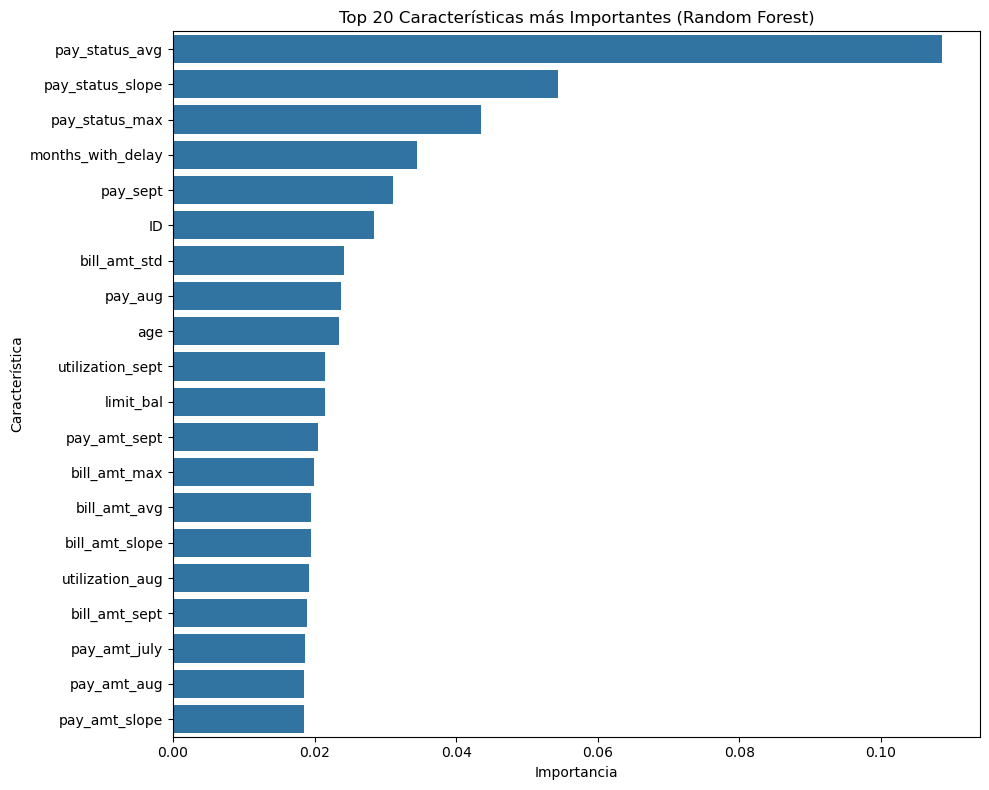

In [57]:
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))
plt.title('Top 20 Características más Importantes (Random Forest)')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()



--- Curva de Precisión-Recall ---


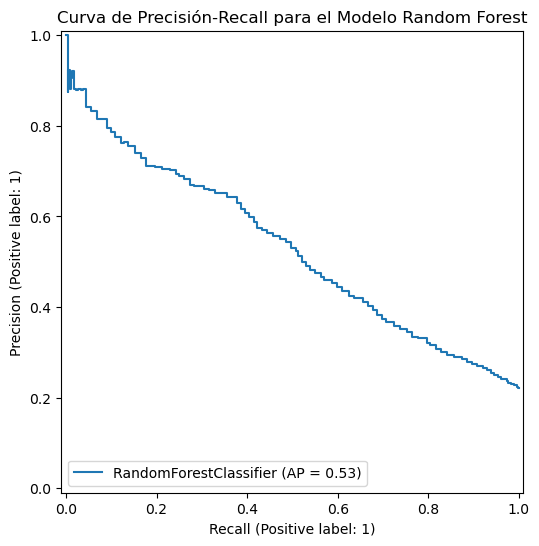

In [58]:
print("\n--- Curva de Precisión-Recall ---")
fig, ax = plt.subplots(figsize=(8, 6))
pr_display = PrecisionRecallDisplay.from_estimator(rf_clf, X_test_scaled, y_test, ax=ax)
plt.title('Curva de Precisión-Recall para el Modelo Random Forest')
plt.savefig('precision_recall_curve.png')
plt.show()

Refinar los Datos: Elimina la columna ID del conjunto de características para evitar que el modelo aprenda de ruido.

In [59]:
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

In [60]:
try:
    project_root = Path.cwd().parent
    features_path = project_root / "data" / "processed" / "features_clasificacion.csv"
    df = pd.read_csv(features_path)
    print("DataFrame con características cargado.")
except FileNotFoundError:
    print(f"Error: No se encontró el archivo en: {features_path}")
    df = None

DataFrame con características cargado.


In [61]:
X = df.drop(['default_payment_next_month', 'ID'], axis=1)
y = df['default_payment_next_month']

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [63]:
print("\n--- Entrenando Modelo XGBoost ---")
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train_scaled, y_train_resampled)
print("Modelo XGBoost entrenado.")


--- Entrenando Modelo XGBoost ---


/opt/anaconda3/envs/riesgo_crediticio_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [01:59:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292871873/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Modelo XGBoost entrenado.


In [64]:
y_pred_xgb = xgb_clf.predict(X_test_scaled)
y_pred_proba_xgb = xgb_clf.predict_proba(X_test_scaled)[:, 1]

In [65]:
print("\n--- Métricas de Evaluación del Modelo XGBoost ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")



--- Métricas de Evaluación del Modelo XGBoost ---
Accuracy: 0.7935
ROC-AUC Score: 0.7489


In [66]:
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_xgb, target_names=['No Incumplimiento (0)', 'Incumplimiento (1)']))


Reporte de Clasificación:
                       precision    recall  f1-score   support

No Incumplimiento (0)       0.85      0.89      0.87      4673
   Incumplimiento (1)       0.54      0.46      0.49      1327

             accuracy                           0.79      6000
            macro avg       0.70      0.67      0.68      6000
         weighted avg       0.78      0.79      0.79      6000



In [67]:
from sklearn.model_selection import RandomizedSearchCV

In [68]:
param_distributions = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

In [69]:
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=rf_clf,
    param_distributions=param_distributions,
    n_iter=50,  # Número de combinaciones a probar
    cv=3,       # Número de validaciones cruzadas
    scoring='f1', # Métrica a optimizar
    verbose=2,
    random_state=42,
    n_jobs=-1
)

In [70]:
random_search.fit(X_train_scaled, y_train_resampled)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  16.0s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  16.5s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  17.0s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  21.0s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  21.2s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  21.5s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=  31.1s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=  31.2s
[CV] END max_depth=10, max_feat

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400]},
                   random_state=42, scoring='f1', verbose=2)

In [71]:
print("\n--- Mejores Hiperparámetros Encontrados ---")
print(random_search.best_params_)


--- Mejores Hiperparámetros Encontrados ---
{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30}


In [72]:
best_rf_clf = random_search.best_estimator_

y_pred_best_rf = best_rf_clf.predict(X_test_scaled)
y_pred_proba_best_rf = best_rf_clf.predict_proba(X_test_scaled)[:, 1]

In [73]:
print("\n--- Métricas de Evaluación del Modelo Random Forest OPTIMIZADO ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best_rf):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_best_rf):.4f}")


--- Métricas de Evaluación del Modelo Random Forest OPTIMIZADO ---
Accuracy: 0.8000
ROC-AUC Score: 0.7603


In [74]:
print("\nReporte de Clasificación (Optimizado):")
print(classification_report(y_test, y_pred_best_rf, target_names=['No Incumplimiento (0)', 'Incumplimiento (1)']))


Reporte de Clasificación (Optimizado):
                       precision    recall  f1-score   support

No Incumplimiento (0)       0.86      0.89      0.87      4673
   Incumplimiento (1)       0.55      0.48      0.52      1327

             accuracy                           0.80      6000
            macro avg       0.71      0.69      0.70      6000
         weighted avg       0.79      0.80      0.80      6000



El Random Forest con parámetros por defecto fue el modelo con mejor rendimiento general para predecir si un cliente incumplirá su pago.

Rendimiento Clave: Se obtuvo un F1-Score de 0.51 para la clase de interés (incumplimiento). Este modelo logró un buen balance, mejorando significativamente la precisión a 0.55 (frente al 0.39 del modelo base), lo que significa que sus alertas de riesgo son más confiables.

Técnicas Esenciales: El éxito del modelo dependió de dos factores clave:

Ingeniería de Características: Las variables que resumían el historial de pagos (como pay_status_avg) resultaron ser las más predictivas.

Balanceo de Clases: El uso de SMOTE en los datos de entrenamiento fue fundamental para que el modelo pudiera identificar correctamente a la clase minoritaria (clientes que incumplen).

Conclusión de Negocio: El modelo es una herramienta valiosa para la gestión de riesgos. Sin embargo, existe un compromiso entre la precisión (evitar falsas alarmas) y el recall (detectar a todos los incumplidores), que debe ajustarse a través del umbral de decisión según la estrategia de negocio.